In [1]:
import sys
sys.path.append('..')

In [2]:
from utils.dataloaders import create_dataloader
from utils.general import (LOGGER, TQDM_BAR_FORMAT, Profile, check_dataset, check_img_size, check_requirements,
                           check_yaml, coco80_to_coco91_class, colorstr, increment_path, non_max_suppression,
                           print_args, scale_boxes, xywh2xyxy, xyxy2xywh)

In [3]:
task = 'val'
dataset_yaml = "../datasets/T16bit_25k_09-03-2023/dataset.yaml"
#dataset_yaml = "../datasets/T8bit_minmax_25k_05-03-2023/dataset.yaml"
data = check_dataset(dataset_yaml)  # check

dataloader, dataset = create_dataloader(
    data[task], # 
    imgsz=640,
    batch_size=16,
    stride=1,
    single_cls=False,
    pad=0.5,
    rect=False,
    augment=False,
    prefix=colorstr(f'{task}: '))

val: Scanning /home/kevinserrano/GitHub/yolov5-extended/datasets/T16bit_25k_09-03-2023/labels/val.cache... 7341 images, 390 backgrounds, 2 corrupt: 100%|██████████| 7341/7341 00:00
val: WARNING ⚠️ /home/kevinserrano/GitHub/yolov5-extended/datasets/T16bit_25k_09-03-2023/images/val/0k_1354692_r.png: 12 duplicate labels removed
val: WARNING ⚠️ /home/kevinserrano/GitHub/yolov5-extended/datasets/T16bit_25k_09-03-2023/images/val/1d_9120754_l.png: 2 duplicate labels removed
val: WARNING ⚠️ /home/kevinserrano/GitHub/yolov5-extended/datasets/T16bit_25k_09-03-2023/images/val/6z_1355074_r.png: 3 duplicate labels removed
val: WARNING ⚠️ /home/kevinserrano/GitHub/yolov5-extended/datasets/T16bit_25k_09-03-2023/images/val/cl_1354653_r.png: 84 duplicate labels removed
val: WARNING ⚠️ /home/kevinserrano/GitHub/yolov5-extended/datasets/T16bit_25k_09-03-2023/images/val/ll_1333457_l.png: ignoring corrupt image/label: negative label values [  -0.027344   -0.017188]
val: WARNING ⚠️ /home/kevinserrano/GitHub

torch.Size([3, 640, 640]) torch.Size([0, 6]) 640 512 (64.0, 0.0)


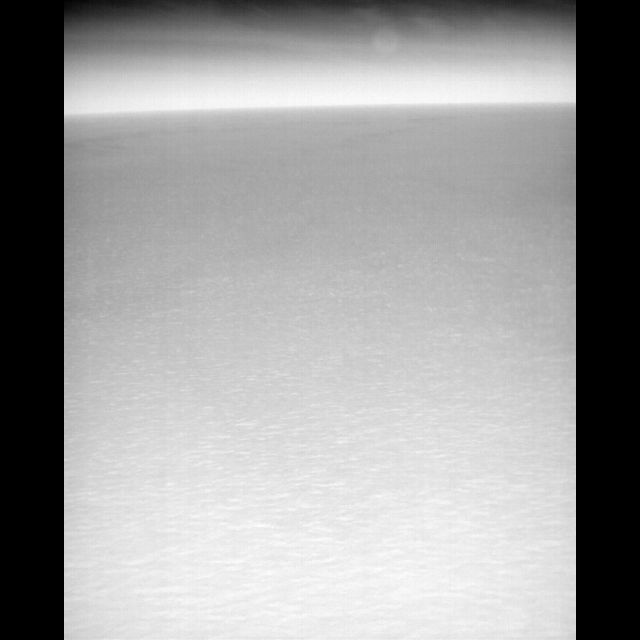

In [4]:
import numpy as np
import cv2
from PIL import Image

for img, labels, im_file, ((h0, w0), (_, pad)) in dataset:
    print(img.shape, labels.shape, h0, w0, pad)
    break

Image.fromarray(img[0].numpy()) #.transpose(1,2,0).astype(np.uint8))

im.dtype=dtype('uint16'), np.ma.minimum_fill_value(im)=65535, np.ma.maximum_fill_value(im)=0


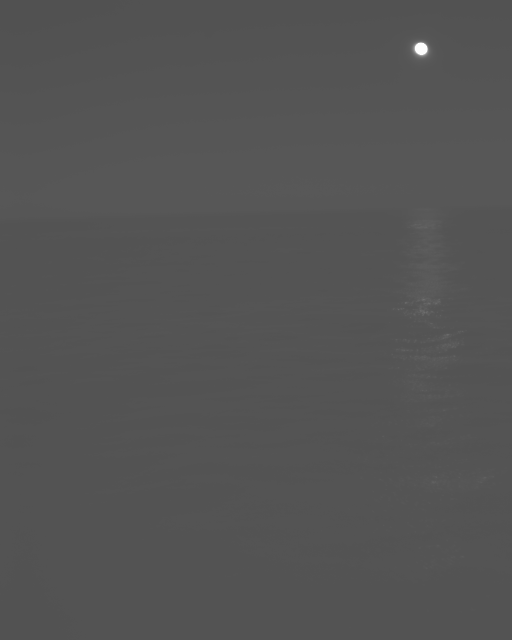

In [5]:
import numpy as np
import cv2

im_fpath = '/mnt/fiftyoneDB/Database/Image_Data/Thermal_Images_16Bit/Trip_310_Seq_153/23714953_r.png'
im = cv2.imread(im_fpath, cv2.IMREAD_UNCHANGED)
print(f"{im.dtype=}, {np.ma.minimum_fill_value(im)=}, {np.ma.maximum_fill_value(im)=}")
Image.fromarray(im)

[     249.98      1.9308      104.62      249.19      251.39      49.323      87.844      169.84      2.8964]


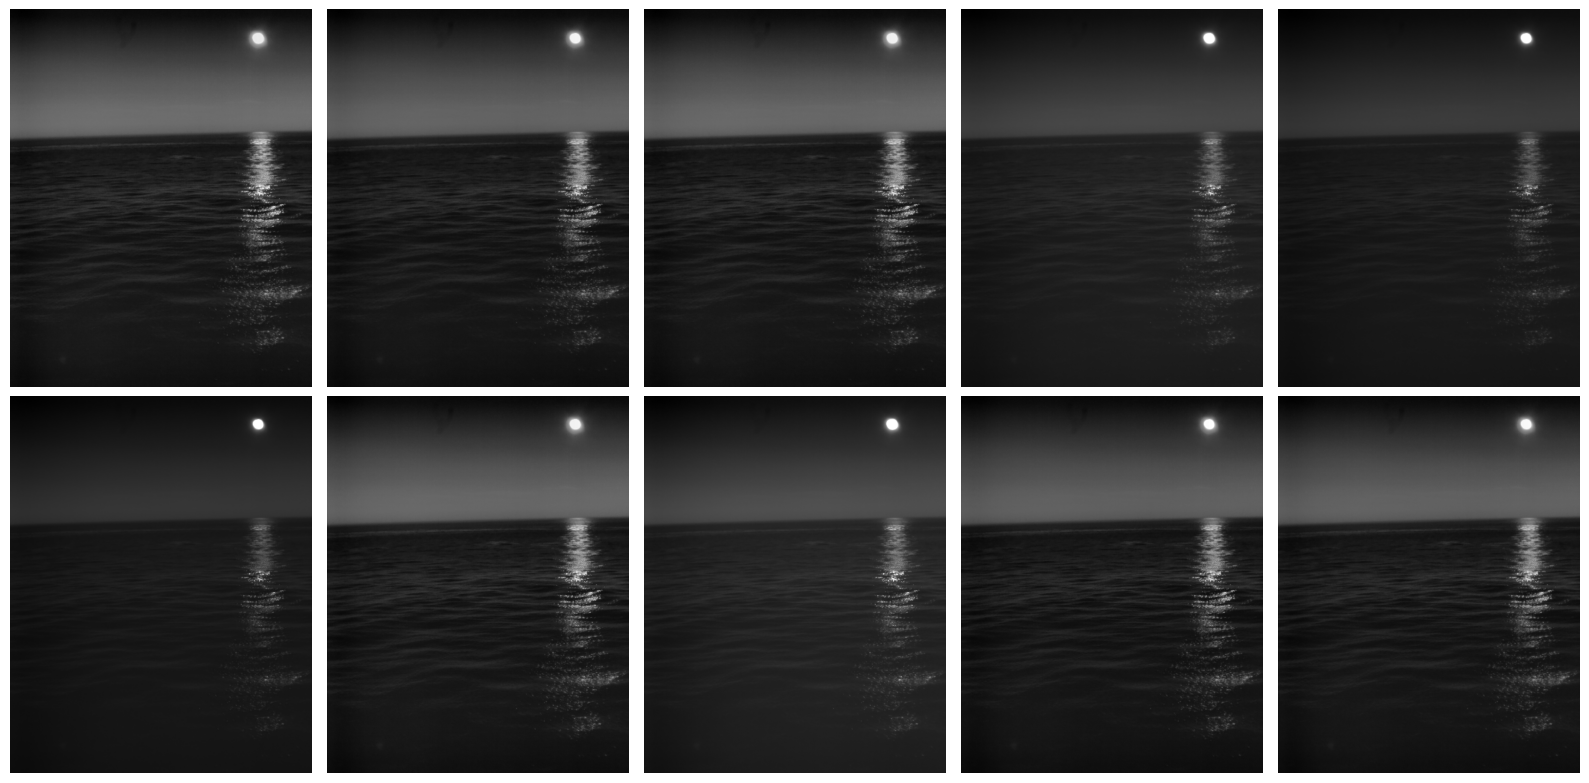

In [6]:
import matplotlib.pyplot as plt
from utils.augmentations16 import convert_16bit_to_8bit

ims = [convert_16bit_to_8bit(im, augment=True) for _ in range(10)]
diffs = np.diff(np.array(ims), axis=0)
print(diffs.mean(axis=(1,2,3)))
# plot images in 4x4 grid
fig, axs = plt.subplots(2, 5, figsize=(16, 8))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(ims[i], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [7]:
import numpy as np
import cv2

im_fpath = '/mnt/fiftyoneDB/Database/Image_Data/Thermal_Images_16Bit/Trip_295_Seq_39/23590222_l.png'
#im_fpath = '/mnt/fiftyoneDB/Database/Image_Data/Thermal_Images_16Bit/Trip_310_Seq_153/23714953_r.png'
#im_fpath = '/mnt/fiftyoneDB/Database/Image_Data/Thermal_Images_16Bit/Trip_161_NoiseSeq_1/4378236_l.png'

im = cv2.imread(im_fpath, cv2.IMREAD_UNCHANGED)
print(f"{im.dtype=}, {np.ma.minimum_fill_value(im)=}, {np.ma.maximum_fill_value(im)=}")

im.dtype=dtype('uint16'), np.ma.minimum_fill_value(im)=65535, np.ma.maximum_fill_value(im)=0


(image - sharp).mean()=7.237936401367188


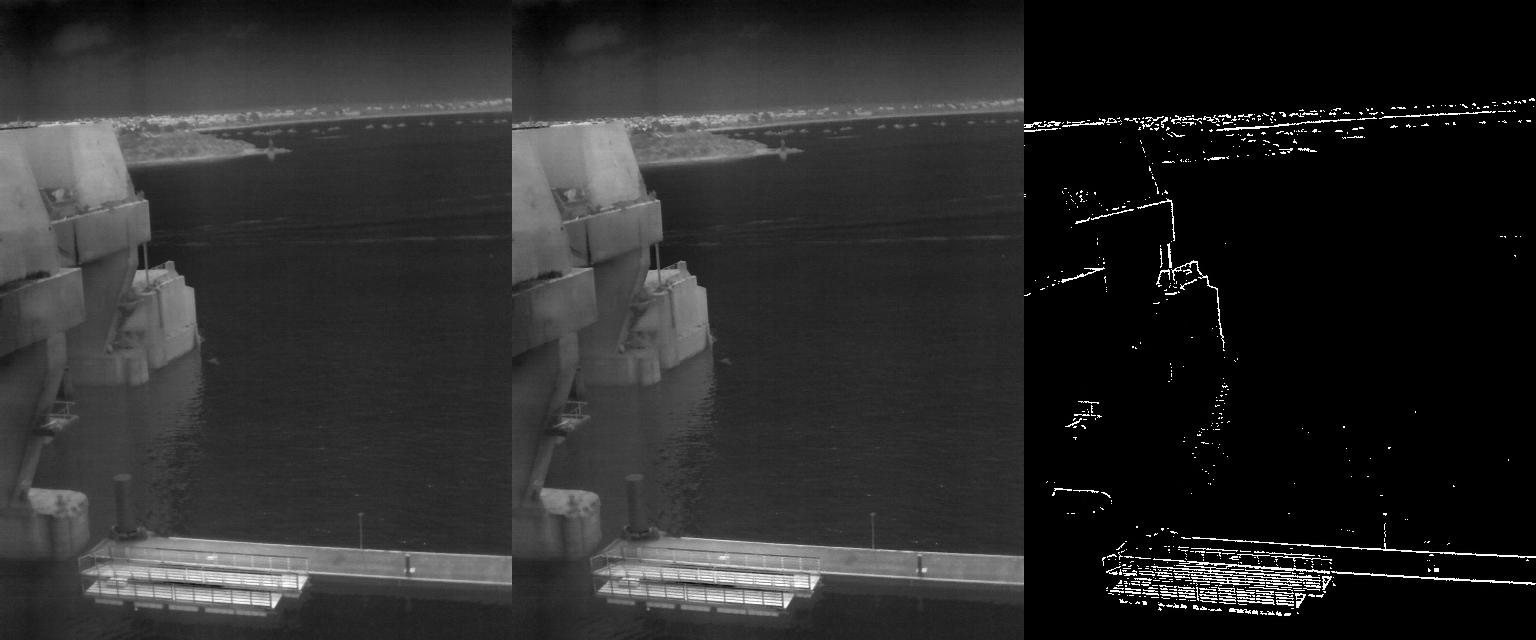

In [8]:
import sys
sys.path.append('..')

from PIL import Image
import albumentations as A
from utils.augmentations16 import CLAHE, Clip, NormalizeMinMax

ksize = 7
sigma = 0.3 * ((ksize-1)*0.5 - 1) + 0.8
llimit = 15000 / 65535
ulimit = 28000 / 65535

transform = A.Compose([
            Clip(p=1.0, lower_limit=(llimit,)*2, upper_limit=(ulimit,)*2),
            CLAHE(p=1, clip_limit=(4, 4), tile_grid_size=(-1, -1)),
            NormalizeMinMax(p=1.0),
            A.ToRGB(p=1.0),
        ])

image = transform(image=im)['image']

transform = A.Compose([
            Clip(p=1.0, lower_limit=(llimit,)*2, upper_limit=(ulimit,)*2),
            CLAHE(p=1, clip_limit=(4, 4), tile_grid_size=(-1, -1)),
            NormalizeMinMax(p=1.0),
            A.UnsharpMask(p=1.0, threshold=5), #, blur_limit=(ksize, ksize), alpha=(0.5, 0.5), sigma_limit=(sigma, sigma)),
            A.ToRGB(p=1.0),
        ])

sharp = transform(image=im)['image']

images = np.concatenate((image, sharp, image-sharp), axis=1)
print(f"{(image - sharp).mean()=}")

Image.fromarray(images)